## Classifying The Simpsons characters
In this project, we want to classify the Simpsons characters using a CNN network. The dataset comes from Kaggle, and you can find that in this [link]('https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset').

In [ ]:
!pip install caer canaro opendatasets

## Importing all the necessary libraries

In [ ]:
import os
import caer
import canaro
import cv2 as cv
import numpy as np
import gc
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l2
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import EarlyStopping

In [ ]:
od.download('https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset')

Skipping, found downloaded files in "./the-simpsons-characters-dataset" (use force=True to force download)


In [ ]:
IMG_SIZE = (80, 80)
DIR = './the-simpsons-characters-dataset/simpsons_dataset'

We just want to claasify the 10 most repeated characters in this dataset:

In [ ]:
characters_dict = {}

for character in os.listdir(DIR):
    character_path = os.path.join(DIR, character)
    characters_dict[character] = len(os.listdir(character_path))

characters_dict = caer.sort_dict(characters_dict, descending=True)
characters_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('gil', 27),
 ('fat_

In [ ]:
ten_chars = [character for (character, rep) in characters_dict[:10]]
ten_chars

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

## Characters dict
We create a simple dictionary with characters indices as keys and their names as values:

In [ ]:
characters_dict = {character: i for i, character in enumerate(ten_chars)}
characters_dict

{'homer_simpson': 0,
 'ned_flanders': 1,
 'moe_szyslak': 2,
 'lisa_simpson': 3,
 'bart_simpson': 4,
 'marge_simpson': 5,
 'krusty_the_clown': 6,
 'principal_skinner': 7,
 'charles_montgomery_burns': 8,
 'milhouse_van_houten': 9}

## Creating training data
Now we have to navigate to each folder which belongs to one one these characters, and add the image and its label to our dataset

In [ ]:
features = []
labels = []

for char in ten_chars:
    char_path = os.path.join(DIR, char)
    for img in os.listdir(char_path):
        img_path = os.path.join(char_path, img)
        img = cv.resize(cv.imread(img_path), IMG_SIZE)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        features.append(img)
        labels.append(characters_dict[char])

In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
features.shape, labels.shape

((13811, 80, 80, 3), (13811,))

## Showing images before scaling:
We randomly choose ten of the pictures and show them using matplotlib

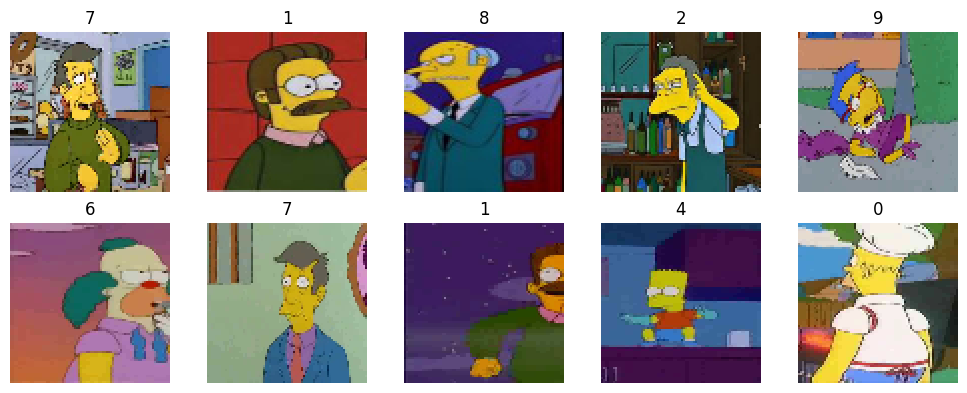

In [ ]:
import matplotlib.pyplot as plt

indices = np.random.choice(len(features), size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, index in enumerate(indices):
    row = i // 5
    col = i % 5
    image = features[index]
    label = labels[index]
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(str(label))

plt.tight_layout()

plt.show()

In [ ]:
min = np.min(features)
max = np.max(features)
print(f'Range of values in images matrices: ({min}-{max})')

Range of values in images matrices: (0-255)


### Scaling
One of the common operations is normalizing the pixel values in images, and map them to values between 0 and 1.

In [ ]:
features = features / 255

In [ ]:
features = features.reshape((-1, 80, 80, 3))
features.shape

(13811, 80, 80, 3)

In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(features, labels, test_size=0.3, random_state=20, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=20, stratify=y_test_val)

### Model
After finetuning and experimanting different models with different architectures and hypermeter values, I reached to this model.

In the CNN part, we have 8 Convolutional layers, following by a Maxpooling and a Dropout layer after each pair of them. After that, we have the ANN part, which consists of 4 Dense layers.

In [ ]:
model = Sequential()
# CNN part
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(80,80,3)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2,2)))
# ANN part
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(10, activation='linear'))

model.compile(optimizer=keras.optimizers.Adam(0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 80, 80, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 80, 80, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 40, 40, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 40, 40, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 40, 40, 64)        36928     
                                                      

## Model Training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, epochs=100, callbacks=[early_stopping])

Epoch 1/100
76/76 [==============================] - 7s 43ms/step - loss: 2.5006 - accuracy: 0.1628 - val_loss: 2.1604 - val_accuracy: 0.2254
Epoch 2/100
76/76 [==============================] - 3s 34ms/step - loss: 2.0416 - accuracy: 0.2851 - val_loss: 1.8542 - val_accuracy: 0.3547
Epoch 3/100
76/76 [==============================] - 3s 34ms/step - loss: 1.7991 - accuracy: 0.3901 - val_loss: 1.6064 - val_accuracy: 0.4556
Epoch 4/100
76/76 [==============================] - 3s 34ms/step - loss: 1.6703 - accuracy: 0.4390 - val_loss: 1.5170 - val_accuracy: 0.5000
Epoch 5/100
76/76 [==============================] - 3s 34ms/step - loss: 1.5895 - accuracy: 0.4698 - val_loss: 1.4156 - val_accuracy: 0.5507
Epoch 6/100
76/76 [==============================] - 3s 34ms/step - loss: 1.5012 - accuracy: 0.5065 - val_loss: 1.4247 - val_accuracy: 0.5681
Epoch 7/100
76/76 [==============================] - 3s 34ms/step - loss: 1.4278 - accuracy: 0.5404 - val_loss: 1.3356 - val_accuracy: 0.5724
Epoch 

## learning Curves

In [ ]:
def plot_learningCurves(train_metric, val_metric, train_label, val_label, metric):
    plt.plot(history.history[train_metric], label=train_label)
    plt.plot(history.history[val_metric], label=val_label)
    plt.xlabel('Ecpochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

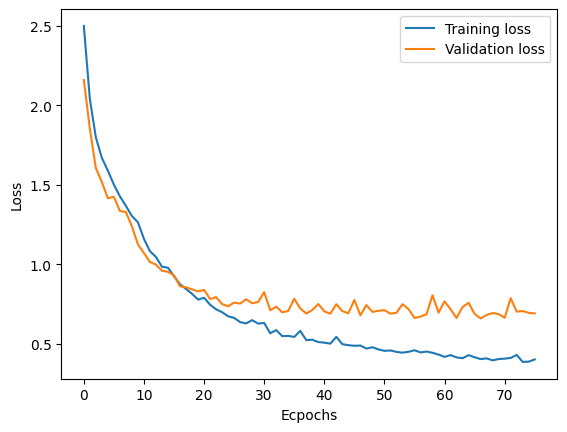

In [ ]:
plot_learningCurves('loss', 'val_loss', 'Training loss', 'Validation loss', 'Loss')

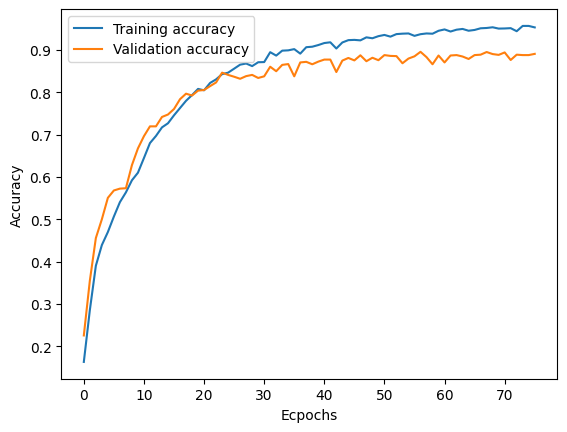

In [ ]:
plot_learningCurves('accuracy', 'val_accuracy', 'Training accuracy', 'Validation accuracy', 'Accuracy')

## Model Evaluation

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
pred.shape

65/65 [==============================] - 0s 3ms/step


(2072,)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       337
           1       0.93      0.95      0.94       218
           2       0.87      0.89      0.88       218
           3       0.89      0.89      0.89       203
           4       0.85      0.89      0.87       202
           5       0.97      0.93      0.95       193
           6       0.80      0.93      0.86       181
           7       0.87      0.88      0.87       179
           8       0.81      0.83      0.82       179
           9       0.96      0.94      0.95       162

    accuracy                           0.89      2072
   macro avg       0.89      0.90      0.89      2072
weighted avg       0.89      0.89      0.89      2072



We reached F1-score of 89, and considering the plotted learning curves, we can find out that our model doesn't suffer from high variance or or high bias.

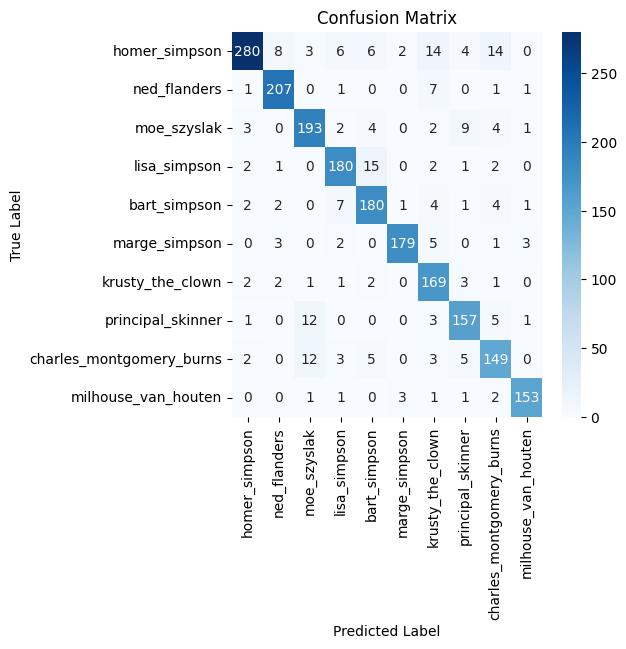

In [ ]:
cm = confusion_matrix(y_test, pred)

classes = characters_dict.keys()

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()